Faced with the given dataset, we start by examining it in terms of various indicators in order to follow up with a more focused and in-depth study of a particular aspect.

We firstly investigate into the ***dataset cleaned_hm & demographic***. After merging the two dataset, it is obvious that some data in age are not reasonable, so we delete those. In addition, some columns such as original_hm and modified are useless to our analyses, so we delete them.

In [33]:
# Import the necessary library
import pandas as pd

# Load the datasets
cleaned_hm_path = '/content/drive/MyDrive/Colab Notebooks/ADS /project1/HappyDB Dataset/HappyDB Dataset/cleaned_hm.csv'  # Adjust path if necessary
demographic_path = '/content/drive/MyDrive/Colab Notebooks/ADS /project1/HappyDB Dataset/HappyDB Dataset/demographic.csv'  # Adjust path if necessary

cleaned_hm_df = pd.read_csv(cleaned_hm_path)
demographic_df = pd.read_csv(demographic_path)

# Merge the datasets on 'wid'
merged_df = pd.merge(cleaned_hm_df, demographic_df, on='wid', how='left')

# Convert 'age' to numeric, setting errors='coerce' to handle non-numeric values
merged_df['age'] = pd.to_numeric(merged_df['age'], errors='coerce')

# Filter to include only rows where age is between 18 and 99
filtered_df = merged_df[(merged_df['age'] >= 18) & (merged_df['age'] <= 99)]

# Drop the 'original_hm', 'modified', and 'ground_truth_category' columns
filtered_df = filtered_df.drop(['original_hm', 'modified', 'ground_truth_category'], axis=1)

# Display the DataFrame - in Jupyter or Colab, just put the variable name
filtered_df.head()  # This will display the DataFrame in a nice format



hmid   wid reflection_period  \
0  27673  2053               24h   
1  27674     2               24h   
2  27675  1936               24h   
3  27676   206               24h   
4  27677  6227               24h   

                                          cleaned_hm  num_sentence  \
0  I went on a successful date with someone I fel...             1   
1  I was happy when my son got 90% marks in his e...             1   
2       I went to the gym this morning and did yoga.             1   
3  We had a serious talk with some friends of our...             2   
4  I went with grandchildren to butterfly display...             1   

  predicted_category   age country gender   marital parenthood  
0          affection  35.0     USA      m    single          n  
1          affection  29.0     IND      m   married          y  
2           exercise  30.0     USA      f   married          y  
3            bonding  28.0     DNK      f   married          n  
4          affection  55.0     USA      f  divorced          y

Generally analyze all category to if there is any significant difference in amount.


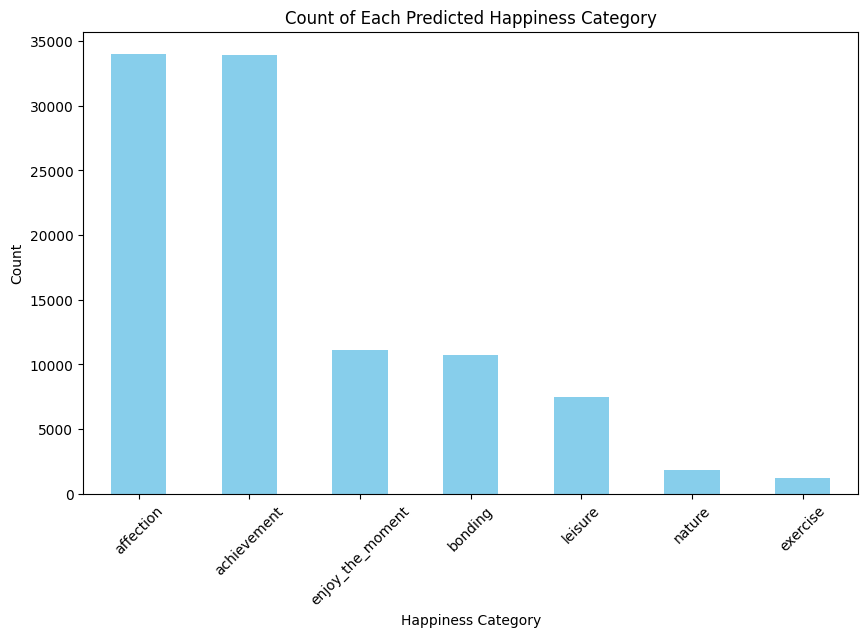

In [34]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'filtered_df' is your DataFrame after previous filtering steps

# Calculate the count of each category in the 'predicted_category' column
category_counts = filtered_df['predicted_category'].value_counts()

# Plotting the counts of each category
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
category_counts.plot(kind='bar', color='skyblue')  # Create a bar chart with a custom color
plt.title('Count of Each Predicted Happiness Category')  # Add a title to the chart
plt.xlabel('Happiness Category')  # Label the x-axis
plt.ylabel('Count')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()  # Display the plot


It is clear to see that categories ***affection*** and ***achievement*** have the largest number of people, and the sample size is large enough for subsequent in-depth research. However, before this can be done, some other aspects also need to be studied in order to further complete the data cleaning.

We are curious that if there exists any difference that comes from nationality, so we caculate the several ratios.

In [35]:
# Calculate the count of USA vs. non-USA citizens within each predicted_category
usa_counts = filtered_df[filtered_df['country'] == 'USA']['predicted_category'].value_counts()
non_usa_counts = filtered_df[filtered_df['country'] != 'USA']['predicted_category'].value_counts()

# Creating a DataFrame to hold the counts for easier comparison
category_comparison_df = pd.DataFrame({'USA': usa_counts, 'Non-USA': non_usa_counts})

# Filling NaN values with 0 for categories that might not exist in one of the subsets
category_comparison_df = category_comparison_df.fillna(0)

# Converting counts to integers (in case filling NaNs made them floats)
category_comparison_df = category_comparison_df.astype(int)

# Adding a column for the percentage of USA citizens within each category
category_comparison_df['USA Proportion'] = (category_comparison_df['USA'] /
                                            (category_comparison_df['USA'] + category_comparison_df['Non-USA'])) * 100

# Rounding the proportions to two decimal places for better readability
category_comparison_df['USA Proportion'] = category_comparison_df['USA Proportion'].round(2)

# Display the updated DataFrame
category_comparison_df


USA  Non-USA  USA Proportion
achievement       27876     6017           82.25
affection         26172     7849           76.93
bonding            7859     2847           73.41
enjoy_the_moment   8613     2506           77.46
exercise           1046      155           87.09
leisure            5696     1750           76.50
nature             1611      229           87.55

As we can plainly see, nationality did not make a significant difference, with both U.S. and non-U.S. citizens being the most likely to be happy in both the achievement and affection categories.

Given the large sample size of U.S. citizens, we examine the data for U.S. citizens only in subsequent analyses.

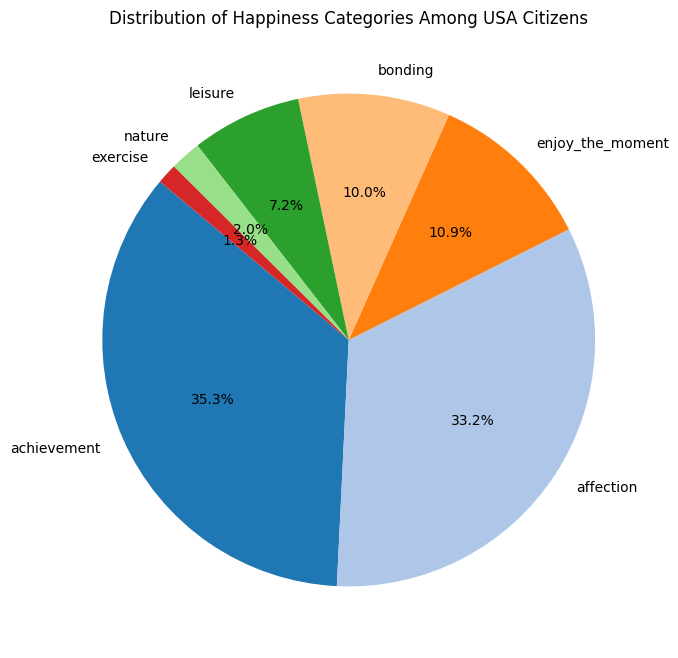

In [36]:
# Filter the DataFrame to keep only rows where the country is 'USA'
usa_only_df = filtered_df[filtered_df['country'] == 'USA']

# Display the first few rows of the USA-only DataFrame to ensure the filtering was done correctly
usa_only_df.head()

# Import the necessary libraries
import matplotlib.pyplot as plt

# Calculate the count of each category for USA citizens
usa_category_counts = usa_only_df['predicted_category'].value_counts()

# Plotting the counts as a pie chart
plt.figure(figsize=(8, 8))  # Set the figure size
usa_category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Distribution of Happiness Categories Among USA Citizens')  # Add a title to the chart
plt.ylabel('')  # Removing the y-label as it's not needed for pie charts
plt.show()  # Display the plot


Intuitively, the sources of pleasure will certainly vary across age groups, so we use age group as the primary differentiator.

Then we examine the age distribution of this sample of U.S. citizens.

<ipython-input-37-3596b4494653>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_only_df['age_group'] = pd.cut(usa_only_df['age'], bins=age_bins, labels=age_labels, right=True)


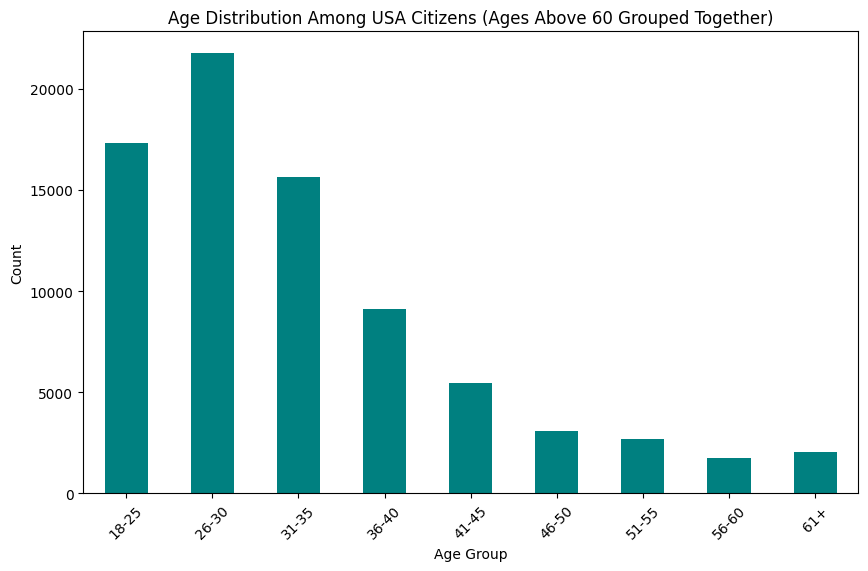

In [37]:
# Redefine age bins and their labels to group all ages above 60 into one category
age_bins = [17, 25, 30, 35, 40, 45, 50, 55, 60, 150]  # Note: 150 as an upper limit to include all ages above 60
age_labels = ['18-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61+']

# Re-categorize the ages into the new bins
usa_only_df['age_group'] = pd.cut(usa_only_df['age'], bins=age_bins, labels=age_labels, right=True)

# Recalculate the count of each new age group
age_group_counts = usa_only_df['age_group'].value_counts(sort=False)  # Ensure counts are sorted by bin order

# Re-plotting the updated counts of each age group
plt.figure(figsize=(10, 6))  # Adjust the figure size for better readability
age_group_counts.plot(kind='bar', color='teal')  # Use a different color for variety
plt.title('Age Distribution Among USA Citizens (Ages Above 60 Grouped Together)')  # Update the title
plt.xlabel('Age Group')  # Label the x-axis
plt.ylabel('Count')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()  # Display the updated plot


Let's take a further look at how the gender distribution is by age group.

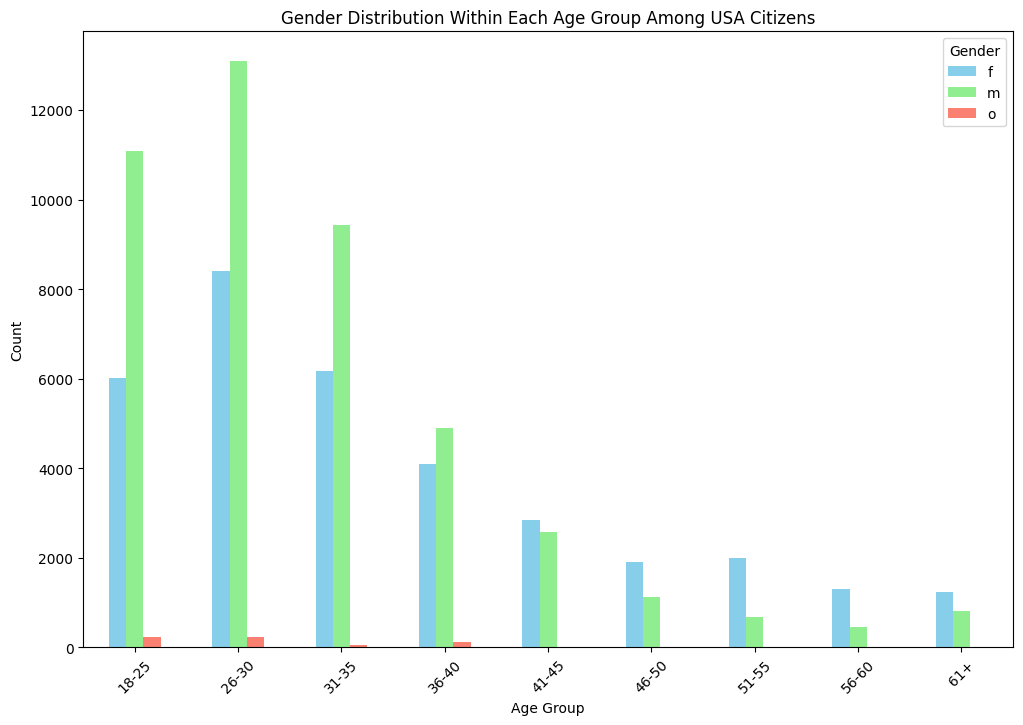

In [38]:
# Calculate the count of each gender within each age group
age_gender_counts = usa_only_df.groupby(['age_group', 'gender']).size().unstack(fill_value=0)

# Plotting the counts of each gender within each age group
age_gender_counts.plot(kind='bar', figsize=(12, 8), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Gender Distribution Within Each Age Group Among USA Citizens')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()


Sex data labeled o were found, and we excluded them before doing the above analysis.

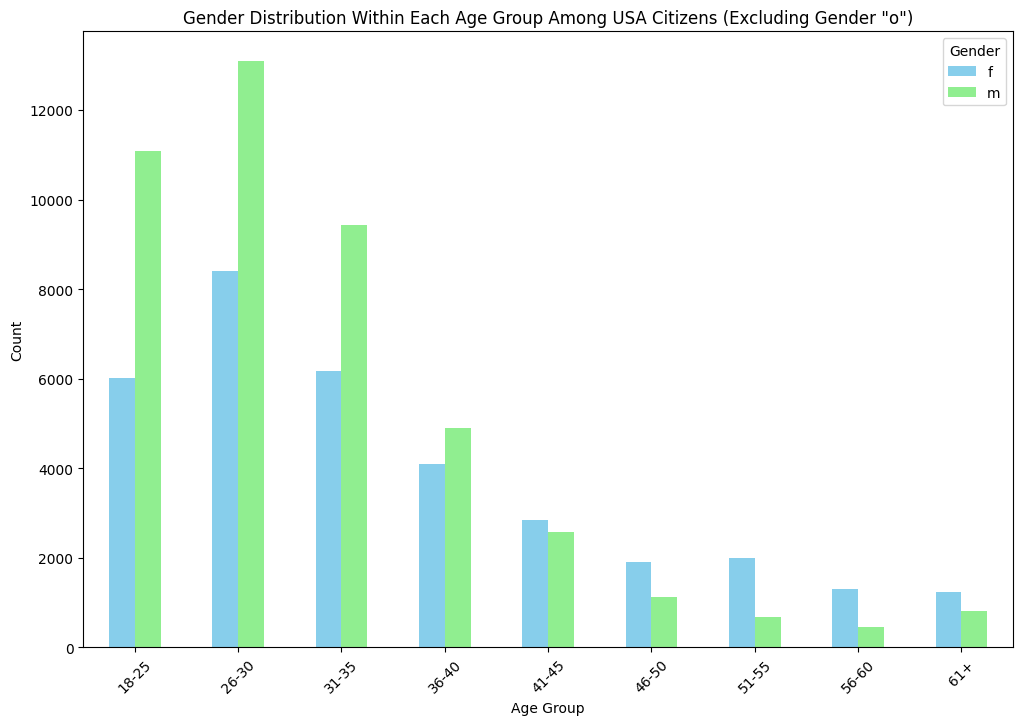

In [39]:
# Filter out rows where gender is labeled as 'o' (assuming 'o' was meant instead of numeric '0')
filtered_gender_o_df = usa_only_df[usa_only_df['gender'] != 'o']

# Recalculate the count of each gender within each age group after filtering out 'o'
filtered_age_gender_o_counts = filtered_gender_o_df.groupby(['age_group', 'gender']).size().unstack(fill_value=0)

# Re-plotting the counts of each gender within each age group after filtering out gender 'o'
filtered_age_gender_o_counts.plot(kind='bar', figsize=(12, 8), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Gender Distribution Within Each Age Group Among USA Citizens (Excluding Gender "o")')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()


Marriages can vary by age, so let's look at the specific distribution by age.

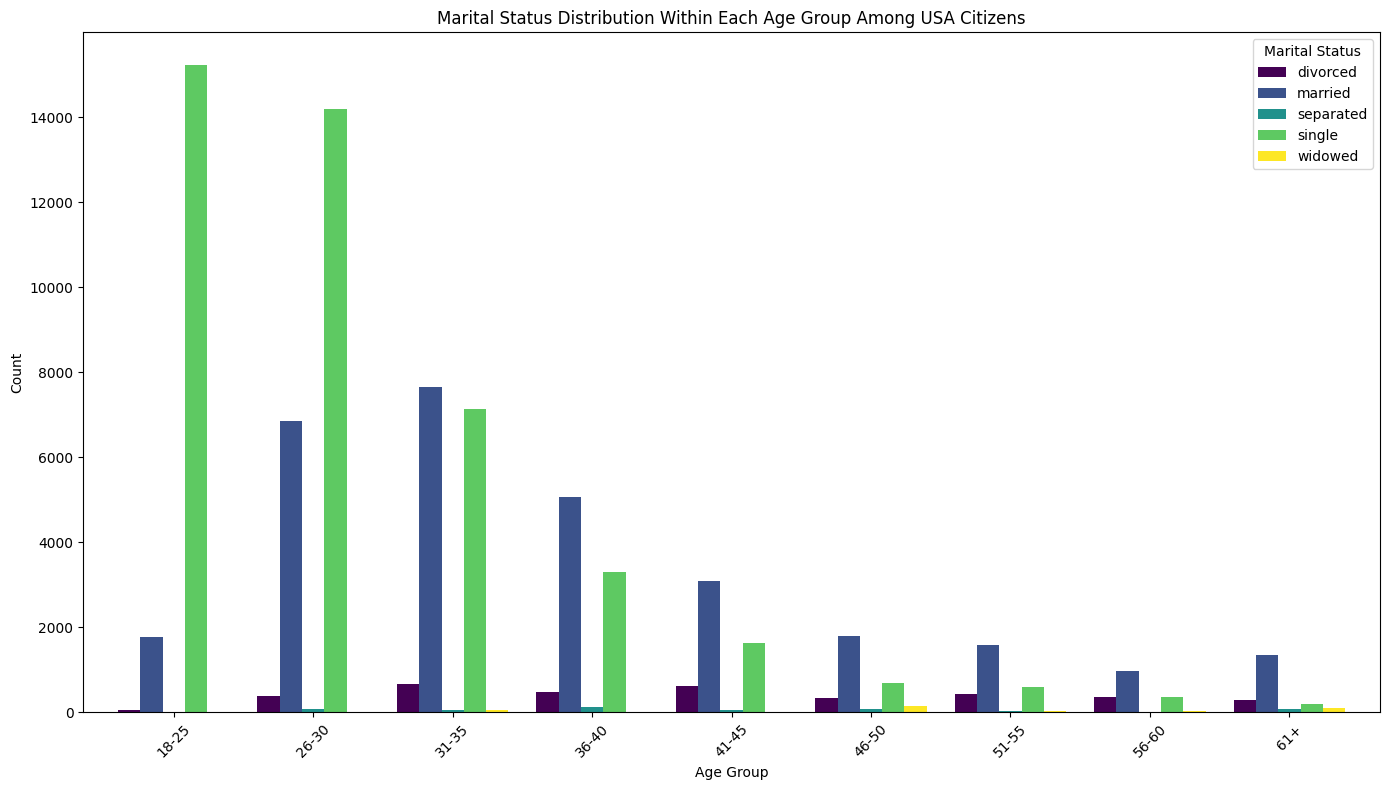

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming filtered_gender_o_df is your DataFrame after excluding gender 'o' and includes 'age_group' and 'marital'

# Calculate the count of each marital status within each age group
age_marital_counts = filtered_gender_o_df.groupby(['age_group', 'marital']).size().unstack(fill_value=0)

# Plotting the counts of each marital status within each age group
age_marital_counts.plot(kind='bar', figsize=(14, 8), width=0.8, colormap='viridis')
plt.title('Marital Status Distribution Within Each Age Group Among USA Citizens')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Marital Status')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


Further, whether or not to become a parent changes with age.

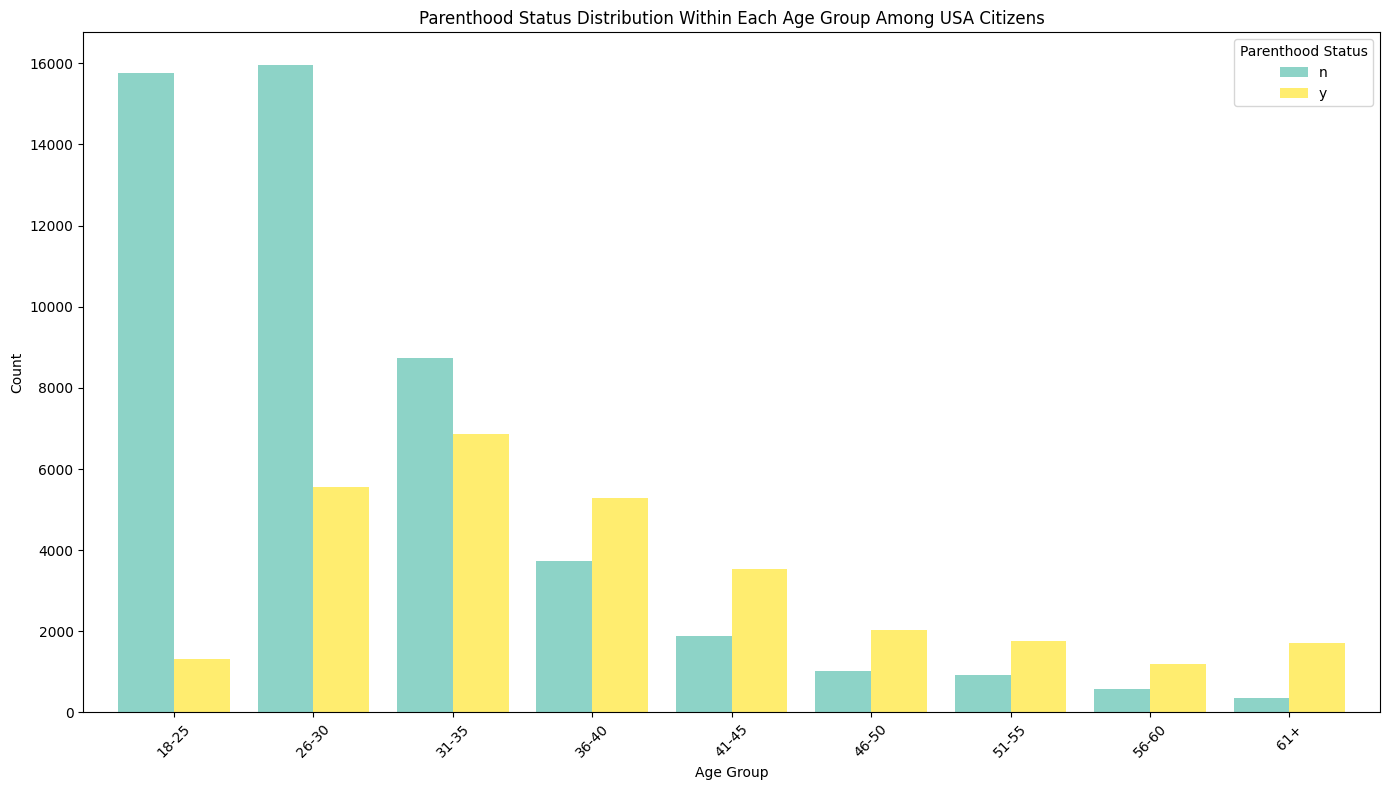

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming filtered_gender_o_df is your DataFrame after excluding unwanted data and includes 'age_group' and 'parenthood'

# Calculate the count of each parenthood status within each age group
age_parenthood_counts = filtered_gender_o_df.groupby(['age_group', 'parenthood']).size().unstack(fill_value=0)

# Plotting the counts of each parenthood status within each age group
age_parenthood_counts.plot(kind='bar', figsize=(14, 8), width=0.8, colormap='Set3')
plt.title('Parenthood Status Distribution Within Each Age Group Among USA Citizens')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Parenthood Status')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


Based on these analyses, we provide an in-depth analysis of some of the source of happiness situations of the younger generation. In this study, the younger generation is considered a sample of two age groups, ***18-25*** and ***26-30***, and subsequent analysis will focus on them.

The sources of happiness were first examined for different groups of people in the ***18-25*** age bracket, taking into account the fact that this group is largely single and childless, and differentiating between the ***sexes*** only.

First we study the group of ***men*** whose happy moment category is ***affection*** and get the hmid for this part of the data.

In [79]:
# Assuming filtered_gender_o_df is your DataFrame and it includes columns for age_group, marital, and predicted_category
criteria_df = filtered_gender_o_df[
    (filtered_gender_o_df['age_group'] == '18-25') &
    (filtered_gender_o_df['marital'] == 'single') &
    (filtered_gender_o_df['predicted_category'] == 'affection') &
    (filtered_gender_o_df['parenthood'] == 'n') &
    (filtered_gender_o_df['gender'] == 'm')
]

# Extracting hmid values for this specific subset
hmids = criteria_df['hmid']

# Display the hmids
print(hmids.head(100))


187     27860
299     27972
301     27974
325     27998
499     28172
        ...  
4573    32279
4649    32357
4934    32643
5037    32749
5224    32938
Name: hmid, Length: 100, dtype: int64


Correspond the hmid to the senselabel dataset and count the keywords in it.

In [80]:
import pandas as pd

# load senselabel.csv
senselabel_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ADS /project1/HappyDB Dataset/HappyDB Dataset/senselabel.csv')

# Assuming hmids is a list of hmid values we're interested in analyzing
#hmids = [12345, 67890]  # Replace with the actual list of hmid values

# Filter the dataset for entries with these hmids and where POS is 'NOUN'
filtered_df = senselabel_df[(senselabel_df['hmid'].isin(hmids)) & (senselabel_df['POS'].isin(['NOUN']))]

# Perform a frequency count of each word within the filtered dataset
word_frequency = filtered_df.groupby('word').size().reset_index(name='count')

# Sort the word frequency count in descending order to see the most common words first
word_frequency_sorted = word_frequency.sort_values('count', ascending=False)

# Display the sorted word frequencies
print(word_frequency_sorted.head(10))


            word  count
902   girlfriend    577
1667        time    250
814       family    222
729          dog    186
694          day    165
970         home    138
503      brother    127
1162         mom    117
714       dinner    115
1520      sister     99


Making statistics into wordcloud. What's clear is that most of them have something to do with relationships, whether it's family bonding, love with a girlfriend or bonding with a pet.And, it is quite obvious that couples bring a high percentage of happiness among young people in this age group.

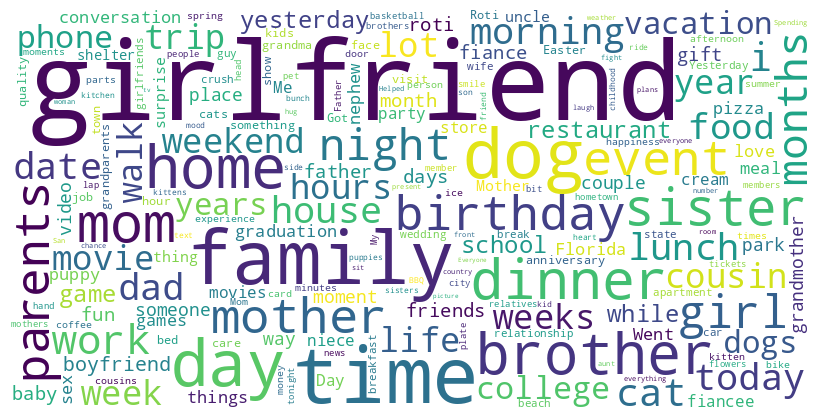

In [81]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the word frequency DataFrame into a dictionary
word_freq_dict = word_frequency_sorted.set_index('word')['count'].to_dict()

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(word_freq_dict)

# Plotting the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Display the word cloud
plt.show()


Similarly, we analyze ***women*** and get extremely similar results.

           word  count
425   boyfriend    372
1505       time    157
628         day    141
662         dog    124
1060        mom     99
734      family     96
1360     sister     86
882        home     81
492         cat     77
1620       work     76


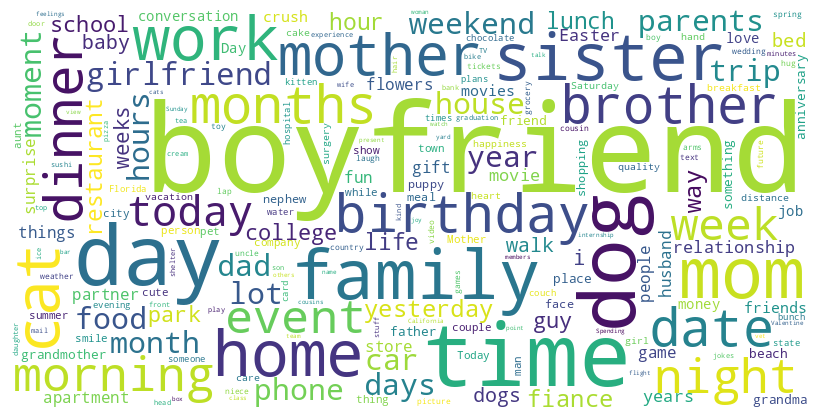

In [82]:
# Assuming filtered_gender_o_df is your DataFrame and it includes columns for age_group, marital, and predicted_category
criteria_df = filtered_gender_o_df[
    (filtered_gender_o_df['age_group'] == '18-25') &
    (filtered_gender_o_df['marital'] == 'single') &
    (filtered_gender_o_df['predicted_category'] == 'affection') &
    (filtered_gender_o_df['parenthood'] == 'n') &
    (filtered_gender_o_df['gender'] == 'f')
]

# Extracting hmid values for this specific subset
hmids = criteria_df['hmid']

# Display the hmids
#print(hmids.head(100))

import pandas as pd

# load senselabel.csv
senselabel_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ADS /project1/HappyDB Dataset/HappyDB Dataset/senselabel.csv')

# Assuming hmids is a list of hmid values we're interested in analyzing
#hmids = [12345, 67890]  # Replace with the actual list of hmid values

# Filter the dataset for entries with these hmids and where POS is 'NOUN'
filtered_df = senselabel_df[(senselabel_df['hmid'].isin(hmids)) & (senselabel_df['POS'].isin(['NOUN']))]

# Perform a frequency count of each word within the filtered dataset
word_frequency = filtered_df.groupby('word').size().reset_index(name='count')

# Sort the word frequency count in descending order to see the most common words first
word_frequency_sorted = word_frequency.sort_values('count', ascending=False)

# Display the sorted word frequencies
print(word_frequency_sorted.head(10))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the word frequency DataFrame into a dictionary
word_freq_dict = word_frequency_sorted.set_index('word')['count'].to_dict()

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(word_freq_dict)

# Plotting the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Display the word cloud
plt.show()


Next we analyze the ***achievement*** category. First, the group of ***men***. Obviously, the main source is career and academic achievement.

         word  count
3131     work    432
1882      job    312
2941     time    232
1309      day    196
2951    today    188
1047      car    174
1166  college    161
2110    money    161
1491    event    149
2114   months    143


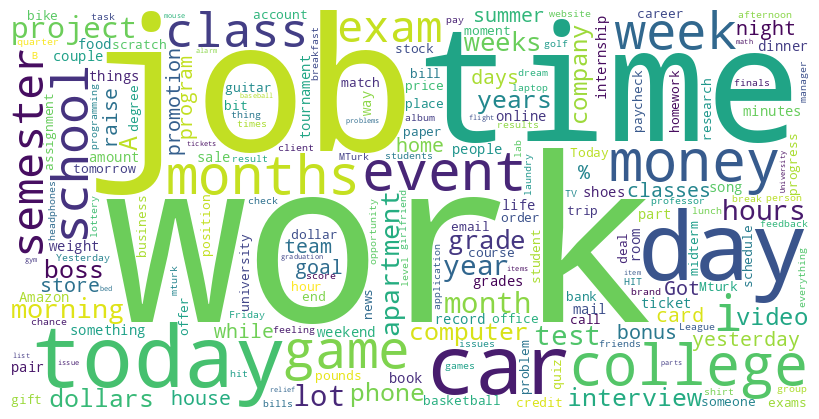

In [83]:
# Assuming filtered_gender_o_df is your DataFrame and it includes columns for age_group, marital, and predicted_category
criteria_df = filtered_gender_o_df[
    (filtered_gender_o_df['age_group'] == '18-25') &
    (filtered_gender_o_df['marital'] == 'single') &
    (filtered_gender_o_df['predicted_category'] == 'achievement') &
    (filtered_gender_o_df['parenthood'] == 'n') &
    (filtered_gender_o_df['gender'] == 'm')
]

# Extracting hmid values for this specific subset
hmids = criteria_df['hmid']

# Display the hmids
#print(hmids.head(100))

import pandas as pd

# load senselabel.csv
senselabel_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ADS /project1/HappyDB Dataset/HappyDB Dataset/senselabel.csv')

# Assuming hmids is a list of hmid values we're interested in analyzing
#hmids = [12345, 67890]  # Replace with the actual list of hmid values

# Filter the dataset for entries with these hmids and where POS is 'NOUN'
filtered_df = senselabel_df[(senselabel_df['hmid'].isin(hmids)) & (senselabel_df['POS'].isin(['NOUN']))]

# Perform a frequency count of each word within the filtered dataset
word_frequency = filtered_df.groupby('word').size().reset_index(name='count')

# Sort the word frequency count in descending order to see the most common words first
word_frequency_sorted = word_frequency.sort_values('count', ascending=False)

# Display the sorted word frequencies
print(word_frequency_sorted.head(10))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the word frequency DataFrame into a dictionary
word_freq_dict = word_frequency_sorted.set_index('word')['count'].to_dict()

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(word_freq_dict)

# Plotting the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Display the word cloud
plt.show()


Then the group of ***women***. With a similar conclusion.

         word  count
1860     work    177
1041      job    170
1744     time    107
1543   school     77
687       day     75
1752    today     69
592   college     61
1190    money     59
562     class     57
1192   months     55


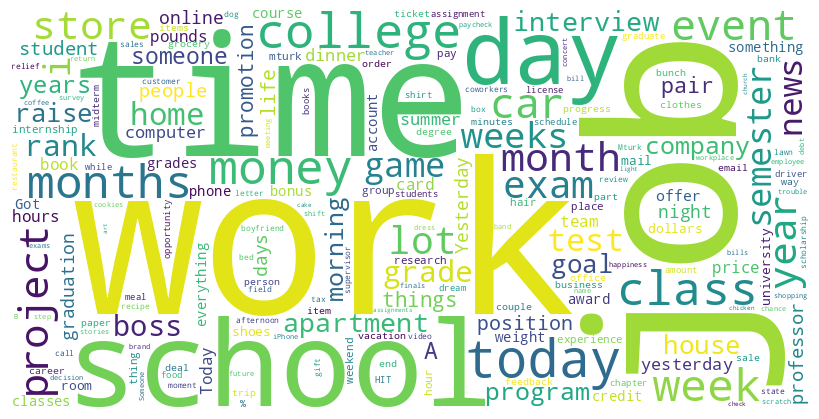

In [84]:
# Assuming filtered_gender_o_df is your DataFrame and it includes columns for age_group, marital, and predicted_category
criteria_df = filtered_gender_o_df[
    (filtered_gender_o_df['age_group'] == '18-25') &
    (filtered_gender_o_df['marital'] == 'single') &
    (filtered_gender_o_df['predicted_category'] == 'achievement') &
    (filtered_gender_o_df['parenthood'] == 'n') &
    (filtered_gender_o_df['gender'] == 'f')
]

# Extracting hmid values for this specific subset
hmids = criteria_df['hmid']

# Display the hmids
#print(hmids.head(100))

import pandas as pd

# load senselabel.csv
senselabel_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ADS /project1/HappyDB Dataset/HappyDB Dataset/senselabel.csv')

# Assuming hmids is a list of hmid values we're interested in analyzing
#hmids = [12345, 67890]  # Replace with the actual list of hmid values

# Filter the dataset for entries with these hmids and where POS is 'NOUN'
filtered_df = senselabel_df[(senselabel_df['hmid'].isin(hmids)) & (senselabel_df['POS'].isin(['NOUN']))]

# Perform a frequency count of each word within the filtered dataset
word_frequency = filtered_df.groupby('word').size().reset_index(name='count')

# Sort the word frequency count in descending order to see the most common words first
word_frequency_sorted = word_frequency.sort_values('count', ascending=False)

# Display the sorted word frequencies
print(word_frequency_sorted.head(10))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the word frequency DataFrame into a dictionary
word_freq_dict = word_frequency_sorted.set_index('word')['count'].to_dict()

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(word_freq_dict)

# Plotting the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Display the word cloud
plt.show()


Given that there was no significant difference between men and women in this age group, we combined the ***affection*** and ***achievement*** categories to create a wordcloud. Then compare it with the one generated from the combination of ***all*** categories as and analyze them again.

First is an analysis that includes only two categories. Considering the higher proportion of women in the sample, it can be concluded that for love, men are somewhat more likely to be happy than women. After the merging of the two categories, a high percentage of moments of pleasure gained from the achievements brought by work can be significantly found.

            word  count
5295        work    750
4984        time    746
2880  girlfriend    626
2294         day    577
3241         job    507
1732   boyfriend    409
4997       today    345
2581       event    335
2643      family    326
2408         dog    324


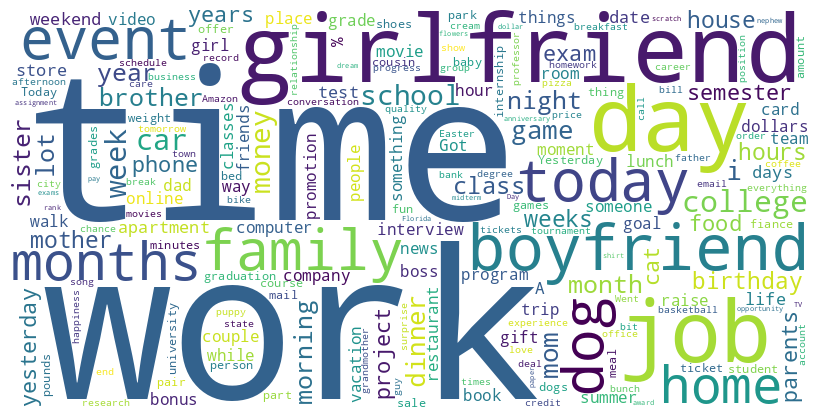

In [85]:
# Assuming filtered_gender_o_df is your DataFrame and it includes columns for age_group, marital, and predicted_category
criteria_df = filtered_gender_o_df[
    (filtered_gender_o_df['age_group'] == '18-25') &
    (filtered_gender_o_df['marital'] == 'single') &
    (filtered_gender_o_df['predicted_category'].isin(['affection', 'achievement'])) &
    (filtered_gender_o_df['parenthood'] == 'n')
    #(filtered_gender_o_df['gender'] == 'f')
]

# Extracting hmid values for this specific subset
hmids = criteria_df['hmid']

# Display the hmids
#print(hmids.head(100))

import pandas as pd

# load senselabel.csv
senselabel_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ADS /project1/HappyDB Dataset/HappyDB Dataset/senselabel.csv')

# Assuming hmids is a list of hmid values we're interested in analyzing
#hmids = [12345, 67890]  # Replace with the actual list of hmid values

# Filter the dataset for entries with these hmids and where POS is 'NOUN'
filtered_df = senselabel_df[(senselabel_df['hmid'].isin(hmids)) & (senselabel_df['POS'].isin(['NOUN']))]

# Perform a frequency count of each word within the filtered dataset
word_frequency = filtered_df.groupby('word').size().reset_index(name='count')

# Sort the word frequency count in descending order to see the most common words first
word_frequency_sorted = word_frequency.sort_values('count', ascending=False)

# Display the sorted word frequencies
print(word_frequency_sorted.head(10))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the word frequency DataFrame into a dictionary
word_freq_dict = word_frequency_sorted.set_index('word')['count'].to_dict()

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(word_freq_dict)

# Plotting the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Display the word cloud
plt.show()

The wordcloud for all categories. It can be seen that for single young people at this stage of life, work, friendship and love continue to be the main sources of happy moments. The difference is that there is a significant increase in the weight of friendship.

            word  count
6465        time   1140
3769      friend   1003
6847        work    939
3167         day    859
3771     friends    817
3861  girlfriend    644
6480       today    613
4316         job    533
3509       event    508
3811        game    485


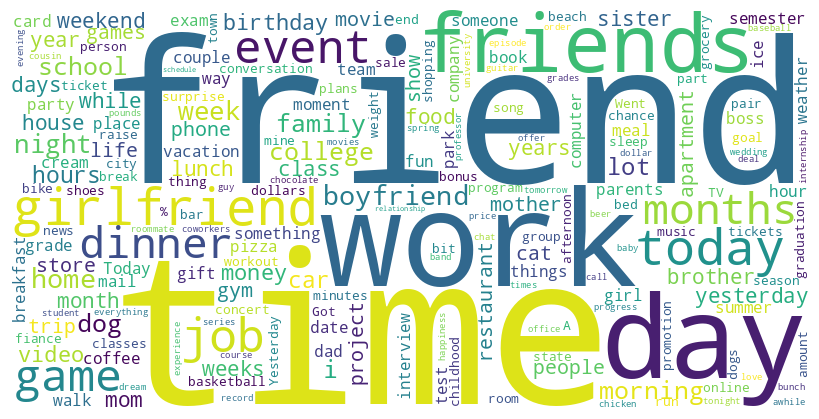

In [86]:
# Assuming filtered_gender_o_df is your DataFrame and it includes columns for age_group, marital, and predicted_category
criteria_df = filtered_gender_o_df[
    (filtered_gender_o_df['age_group'] == '18-25') &
    (filtered_gender_o_df['parenthood'] == 'n') &
    (filtered_gender_o_df['marital'] == 'single')
    #(filtered_gender_o_df['predicted_category'].isin(['affection', 'achievement']))
    #(filtered_gender_o_df['gender'] == 'f')
]

# Extracting hmid values for this specific subset
hmids = criteria_df['hmid']

# Display the hmids
#print(hmids.head(100))

import pandas as pd

# load senselabel.csv
senselabel_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ADS /project1/HappyDB Dataset/HappyDB Dataset/senselabel.csv')

# Assuming hmids is a list of hmid values we're interested in analyzing
#hmids = [12345, 67890]  # Replace with the actual list of hmid values

# Filter the dataset for entries with these hmids and where POS is 'NOUN'
filtered_df = senselabel_df[(senselabel_df['hmid'].isin(hmids)) & (senselabel_df['POS'].isin(['NOUN']))]

# Perform a frequency count of each word within the filtered dataset
word_frequency = filtered_df.groupby('word').size().reset_index(name='count')

# Sort the word frequency count in descending order to see the most common words first
word_frequency_sorted = word_frequency.sort_values('count', ascending=False)

# Display the sorted word frequencies
print(word_frequency_sorted.head(10))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the word frequency DataFrame into a dictionary
word_freq_dict = word_frequency_sorted.set_index('word')['count'].to_dict()

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(word_freq_dict)

# Plotting the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Display the word cloud
plt.show()

In the ***26-30*** age group, we similarly analyzed the unmarried, childless population to facilitate comparisons with data samples from previous age groups. First, group of ***men & affection***. No significant difference from the ***18-25*** group.

            word  count
922   girlfriend    346
760          dog    233
842       family    226
1689        time    188
723          day    134
1003        home    115
1203         mom    109
535      brother    105
746       dinner    100
1216      mother     90


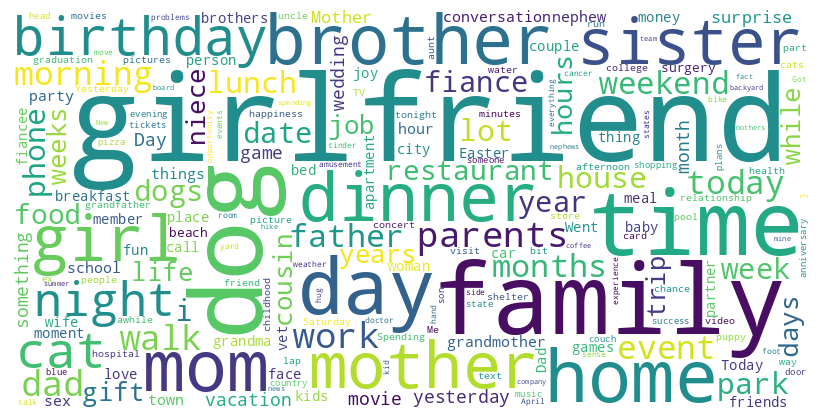

In [87]:
# Assuming filtered_gender_o_df is your DataFrame and it includes columns for age_group, marital, and predicted_category
criteria_df = filtered_gender_o_df[
    (filtered_gender_o_df['age_group'] == '26-30') &
    (filtered_gender_o_df['marital'] == 'single') &
    (filtered_gender_o_df['predicted_category'] == 'affection') &
    (filtered_gender_o_df['parenthood'] == 'n') &
    (filtered_gender_o_df['gender'] == 'm')
]

# Extracting hmid values for this specific subset
hmids = criteria_df['hmid']

# Filter the dataset for entries with these hmids and where POS is 'NOUN'
filtered_df = senselabel_df[(senselabel_df['hmid'].isin(hmids)) & (senselabel_df['POS'].isin(['NOUN']))]

# Perform a frequency count of each word within the filtered dataset
word_frequency = filtered_df.groupby('word').size().reset_index(name='count')

# Sort the word frequency count in descending order to see the most common words first
word_frequency_sorted = word_frequency.sort_values('count', ascending=False)

# Display the sorted word frequencies
print(word_frequency_sorted.head(10))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the word frequency DataFrame into a dictionary
word_freq_dict = word_frequency_sorted.set_index('word')['count'].to_dict()

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(word_freq_dict)

# Plotting the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Display the word cloud
plt.show()

Then, group of ***women & affection***. No significant difference from the ***18-25*** group.

           word  count
364   boyfriend    230
1255       time    131
599      family    115
541         dog    104
870         mom     89
530      dinner     76
507         day     75
1139     sister     74
405         cat     70
718        home     64


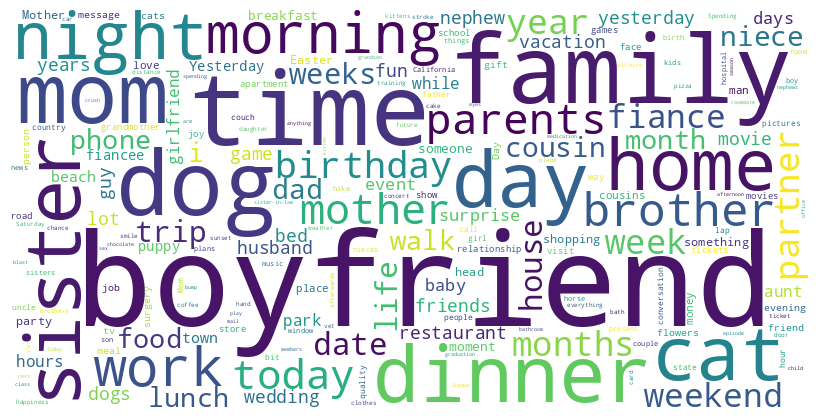

In [88]:
# Assuming filtered_gender_o_df is your DataFrame and it includes columns for age_group, marital, and predicted_category
criteria_df = filtered_gender_o_df[
    (filtered_gender_o_df['age_group'] == '26-30') &
    (filtered_gender_o_df['marital'] == 'single') &
    (filtered_gender_o_df['predicted_category'] == 'affection') &
    (filtered_gender_o_df['parenthood'] == 'n') &
    (filtered_gender_o_df['gender'] == 'f')
]

# Extracting hmid values for this specific subset
hmids = criteria_df['hmid']

# Filter the dataset for entries with these hmids and where POS is 'NOUN'
filtered_df = senselabel_df[(senselabel_df['hmid'].isin(hmids)) & (senselabel_df['POS'].isin(['NOUN']))]

# Perform a frequency count of each word within the filtered dataset
word_frequency = filtered_df.groupby('word').size().reset_index(name='count')

# Sort the word frequency count in descending order to see the most common words first
word_frequency_sorted = word_frequency.sort_values('count', ascending=False)

# Display the sorted word frequencies
print(word_frequency_sorted.head(10))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the word frequency DataFrame into a dictionary
word_freq_dict = word_frequency_sorted.set_index('word')['count'].to_dict()

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(word_freq_dict)

# Plotting the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Display the word cloud
plt.show()

Then, group of ***men & achievement***. No significant difference from the ***18-25*** group.

        word  count
3056    work    477
1807     job    264
2855    time    191
1258     day    170
2034   money    158
2866   today    157
1737       i    144
987      car    133
2040  months    119
3017    week    117


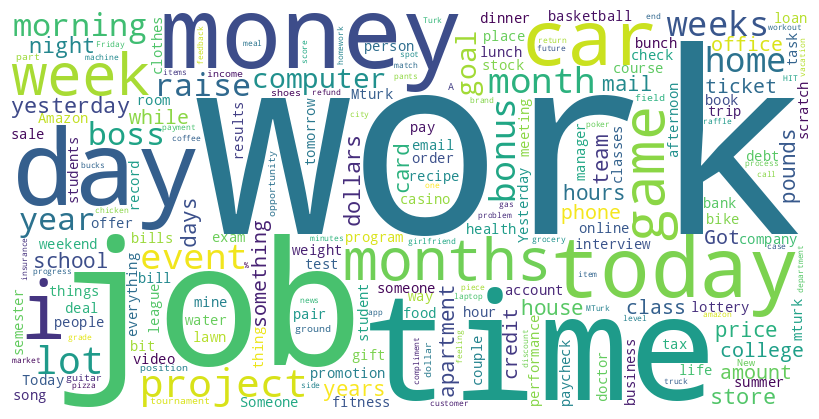

In [89]:
# Assuming filtered_gender_o_df is your DataFrame and it includes columns for age_group, marital, and predicted_category
criteria_df = filtered_gender_o_df[
    (filtered_gender_o_df['age_group'] == '26-30') &
    (filtered_gender_o_df['marital'] == 'single') &
    (filtered_gender_o_df['predicted_category'] == 'achievement') &
    (filtered_gender_o_df['parenthood'] == 'n') &
    (filtered_gender_o_df['gender'] == 'm')
]

# Extracting hmid values for this specific subset
hmids = criteria_df['hmid']

# Filter the dataset for entries with these hmids and where POS is 'NOUN'
filtered_df = senselabel_df[(senselabel_df['hmid'].isin(hmids)) & (senselabel_df['POS'].isin(['NOUN']))]

# Perform a frequency count of each word within the filtered dataset
word_frequency = filtered_df.groupby('word').size().reset_index(name='count')

# Sort the word frequency count in descending order to see the most common words first
word_frequency_sorted = word_frequency.sort_values('count', ascending=False)

# Display the sorted word frequencies
print(word_frequency_sorted.head(10))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the word frequency DataFrame into a dictionary
word_freq_dict = word_frequency_sorted.set_index('word')['count'].to_dict()

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(word_freq_dict)

# Plotting the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Display the word cloud
plt.show()

Then, group of ***women & achievement***. No significant difference from the ***18-25*** group.

        word  count
1769    work    173
1000     job    158
1656    time     71
1134   money     66
1136  months     55
642      day     49
1662   today     49
1750    week     49
1135   month     44
406     boss     41


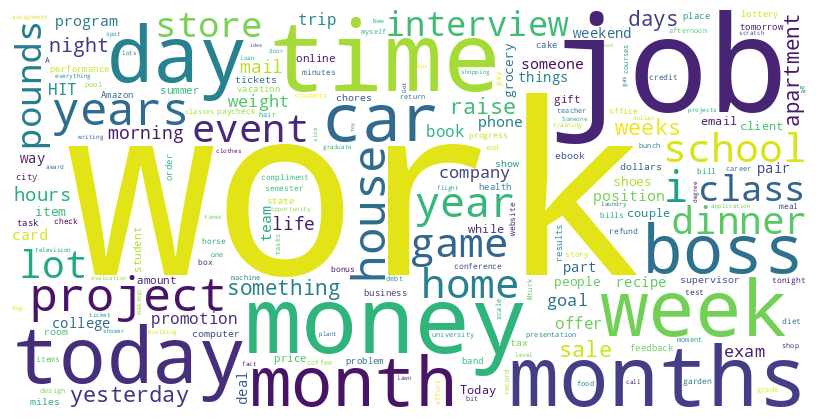

In [90]:
# Assuming filtered_gender_o_df is your DataFrame and it includes columns for age_group, marital, and predicted_category
criteria_df = filtered_gender_o_df[
    (filtered_gender_o_df['age_group'] == '26-30') &
    (filtered_gender_o_df['marital'] == 'single') &
    (filtered_gender_o_df['predicted_category'] == 'achievement') &
    (filtered_gender_o_df['parenthood'] == 'n') &
    (filtered_gender_o_df['gender'] == 'f')
]

# Extracting hmid values for this specific subset
hmids = criteria_df['hmid']

# Filter the dataset for entries with these hmids and where POS is 'NOUN'
filtered_df = senselabel_df[(senselabel_df['hmid'].isin(hmids)) & (senselabel_df['POS'].isin(['NOUN']))]

# Perform a frequency count of each word within the filtered dataset
word_frequency = filtered_df.groupby('word').size().reset_index(name='count')

# Sort the word frequency count in descending order to see the most common words first
word_frequency_sorted = word_frequency.sort_values('count', ascending=False)

# Display the sorted word frequencies
print(word_frequency_sorted.head(10))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the word frequency DataFrame into a dictionary
word_freq_dict = word_frequency_sorted.set_index('word')['count'].to_dict()

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(word_freq_dict)

# Plotting the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Display the word cloud
plt.show()

Given that there was no significant difference between men and women in this age group, we combined the ***affection*** and ***achievement*** categories to create a wordcloud. Then compare it with the one generated from the combination of ***all*** categories as and analyze them again.

First is an analysis that includes only two categories. Considering the higher proportion of women in the sample, it can be concluded that for love, men are somewhat more likely to be happy than women. After the merging of the two categories, a high percentage of moments of pleasure gained from the achievements brought by work can be significantly found. But it is also clear that there is a significant decline in the moments of joy that come from male-female friendships.

            word  count
5057        work    761
4751        time    581
3080         job    459
2170         day    428
2742  girlfriend    375
2517      family    348
2293         dog    345
4766       today    294
2915        home    280
3455      months    252


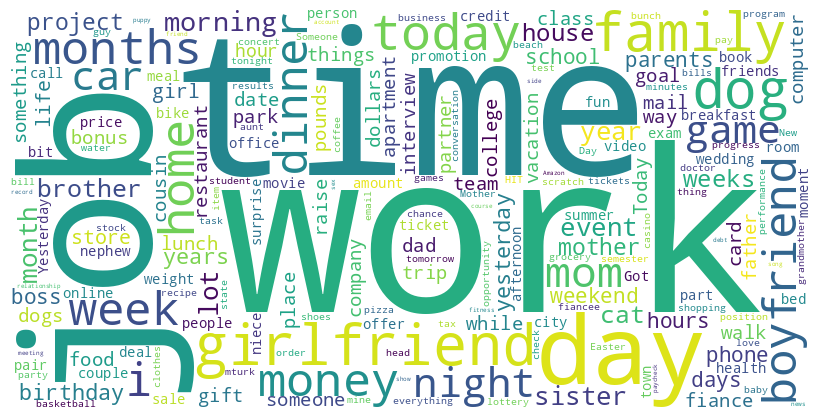

In [91]:
# Assuming filtered_gender_o_df is your DataFrame and it includes columns for age_group, marital, and predicted_category
criteria_df = filtered_gender_o_df[
    (filtered_gender_o_df['age_group'] == '26-30') &
    (filtered_gender_o_df['marital'] == 'single') &
    (filtered_gender_o_df['predicted_category'].isin(['affection', 'achievement'])) &
    (filtered_gender_o_df['parenthood'] == 'n')
    #(filtered_gender_o_df['gender'] == 'f')
]

# Extracting hmid values for this specific subset
hmids = criteria_df['hmid']

# Display the hmids
#print(hmids.head(100))

import pandas as pd

# load senselabel.csv
senselabel_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ADS /project1/HappyDB Dataset/HappyDB Dataset/senselabel.csv')

# Assuming hmids is a list of hmid values we're interested in analyzing
#hmids = [12345, 67890]  # Replace with the actual list of hmid values

# Filter the dataset for entries with these hmids and where POS is 'NOUN'
filtered_df = senselabel_df[(senselabel_df['hmid'].isin(hmids)) & (senselabel_df['POS'].isin(['NOUN']))]

# Perform a frequency count of each word within the filtered dataset
word_frequency = filtered_df.groupby('word').size().reset_index(name='count')

# Sort the word frequency count in descending order to see the most common words first
word_frequency_sorted = word_frequency.sort_values('count', ascending=False)

# Display the sorted word frequencies
print(word_frequency_sorted.head(10))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the word frequency DataFrame into a dictionary
word_freq_dict = word_frequency_sorted.set_index('word')['count'].to_dict()

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(word_freq_dict)

# Plotting the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Display the word cloud
plt.show()

The wordcloud for all categories. The difference is that moments of joy from love are significantly lower, but the share of work and friendship remains high.

         word  count
6726     work    981
6349     time    943
3725   friend    840
3108      day    727
3728  friends    615
6367    today    488
4247      job    487
3774     game    454
4820    night    425
3213   dinner    412


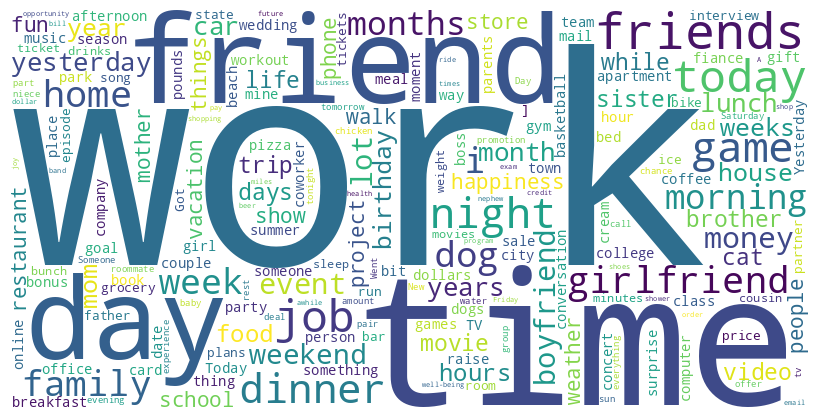

In [92]:
# Assuming filtered_gender_o_df is your DataFrame and it includes columns for age_group, marital, and predicted_category
criteria_df = filtered_gender_o_df[
    (filtered_gender_o_df['age_group'] == '26-30') &
    (filtered_gender_o_df['marital'] == 'single') &
    (filtered_gender_o_df['parenthood'] == 'n')
]

# Extracting hmid values for this specific subset
hmids = criteria_df['hmid']

# Display the hmids
#print(hmids.head(100))

import pandas as pd

# load senselabel.csv
senselabel_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ADS /project1/HappyDB Dataset/HappyDB Dataset/senselabel.csv')

# Assuming hmids is a list of hmid values we're interested in analyzing
#hmids = [12345, 67890]  # Replace with the actual list of hmid values

# Filter the dataset for entries with these hmids and where POS is 'NOUN'
filtered_df = senselabel_df[(senselabel_df['hmid'].isin(hmids)) & (senselabel_df['POS'].isin(['NOUN']))]

# Perform a frequency count of each word within the filtered dataset
word_frequency = filtered_df.groupby('word').size().reset_index(name='count')

# Sort the word frequency count in descending order to see the most common words first
word_frequency_sorted = word_frequency.sort_values('count', ascending=False)

# Display the sorted word frequencies
print(word_frequency_sorted.head(10))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the word frequency DataFrame into a dictionary
word_freq_dict = word_frequency_sorted.set_index('word')['count'].to_dict()

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(word_freq_dict)

# Plotting the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Display the word cloud
plt.show()

So let's take a look at what that looks like across the entire dataset. As you can see, it continues to be work and friendship that bring the highest percentage of happy moments across the entire dataset.

           word  count
17954      time   6247
18906      work   5726
9895        day   4767
11351    friend   4310
18000     today   3332
11358   friends   2878
14204     night   2817
9889   daughter   2726
12197      home   2701
10906    family   2683


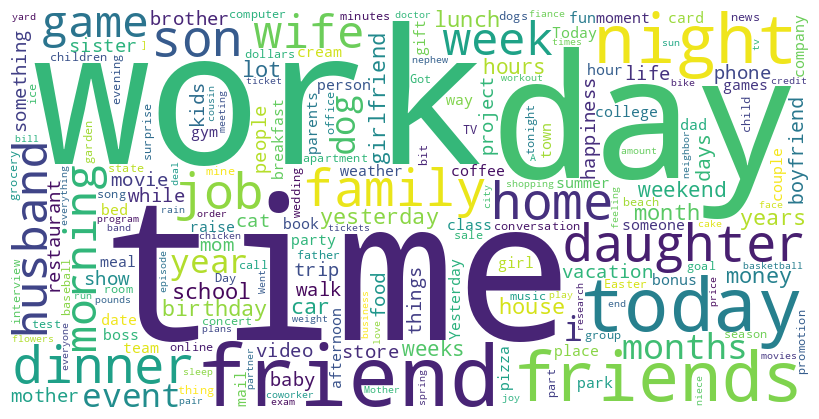

In [93]:
# Assuming filtered_gender_o_df is your DataFrame and it includes columns for age_group, marital, and predicted_category
criteria_df = filtered_gender_o_df

# Extracting hmid values for this specific subset
hmids = criteria_df['hmid']

# Display the hmids
#print(hmids.head(100))

import pandas as pd

# load senselabel.csv
senselabel_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ADS /project1/HappyDB Dataset/HappyDB Dataset/senselabel.csv')

# Assuming hmids is a list of hmid values we're interested in analyzing
#hmids = [12345, 67890]  # Replace with the actual list of hmid values

# Filter the dataset for entries with these hmids and where POS is 'NOUN'
filtered_df = senselabel_df[(senselabel_df['hmid'].isin(hmids)) & (senselabel_df['POS'].isin(['NOUN']))]

# Perform a frequency count of each word within the filtered dataset
word_frequency = filtered_df.groupby('word').size().reset_index(name='count')

# Sort the word frequency count in descending order to see the most common words first
word_frequency_sorted = word_frequency.sort_values('count', ascending=False)

# Display the sorted word frequencies
print(word_frequency_sorted.head(10))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the word frequency DataFrame into a dictionary
word_freq_dict = word_frequency_sorted.set_index('word')['count'].to_dict()

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(word_freq_dict)

# Plotting the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Display the word cloud
plt.show()